# Haar Wavelets + TV Regularization

In [1]:
import matplotlib.pyplot as plt
import pydicom
import numpy as np 
from skimage import img_as_float
from skimage.restoration import denoise_tv_chambolle
from matplotlib import pyplot as plt
from skimage import io
from skimage.metrics import peak_signal_noise_ratio
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import structural_similarity

First display the plot of the full dose image.

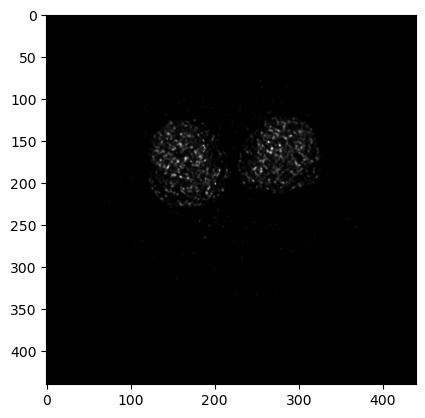

In [2]:
filePath = '/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.644.2022.06.09.18.13.47.251000.4.0.193454626.IMA'
img = pydicom.read_file(filePath) #full dose image
plt.imshow(img.pixel_array, cmap='gray')
plt.show(img) #plot of full dose PET scan

In comparison, here is the plot of the 1-100 dose image. 

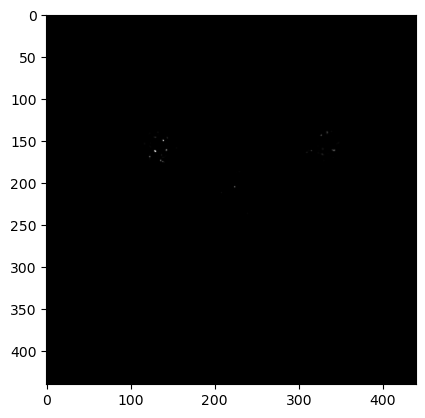

In [3]:
filePath2 = '/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-100 dose/09062022_1.PT.22.1.2022.06.09.17.33.23.131000.4.0.193684044.IMA'
img2 = pydicom.read_file(filePath2) #1-100 dose image
plt.imshow(img2.pixel_array, cmap='gray')
plt.show(img2) #plot of full dose PET scan

The full dose image will be used as a refersnce and refered to as I.

In [4]:
#full dose image 
I = img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/Full_dose/09062022_1.PT.8.644.2022.06.09.18.13.47.251000.4.0.193454626.IMA"))


## Functions for Haar Wavelet, Inverse Haar Wavelet, and TV+Haar Wavelet

In [5]:
#functions below for the 2D Haar Wavelet Transformation and inverse Transformation.
def haar_wavelet(f,depth=None):
    """Haar wavelet transform

    Args:
        f: image
        depth: Depth of the transform

    Returns:
        Haar wavelet transform of f
    """

    n = f.shape[0]
    n2 = n>>1
    g = np.zeros_like(f)
    if depth is None:
        depth = np.log2(n)

    #Wavelet filters
    A = f[::2,::2]; B = f[::2,1::2]; C = f[1::2,::2]; D = f[1::2,1::2]
    g[:n2,:n2]         = (+ A + B + C + D) #approximation coeff
    g[n2:2*n2,:n2]     = (- A - B + C + D) #Horizontal detail
    g[:n2,n2:2*n2]     = (- A + B - C + D) #Vertical detail
    g[n2:2*n2,n2:2*n2] = (+ A - B - C + D) #Diagonal detail

    #Recurse
    if depth >= 2:
        g[:n2,:n2] = haar_wavelet(g[:n2,:n2],depth=depth-1)

    return g

def inverse_haar_wavelet(f,depth=None):
    """Haar wavelet transform

    Args:
        f: image
        depth: Depth of the transform

    Returns:
        Haar wavelet transform of f
    """

    n = f.shape[0]
    n2 = n>>1
    g = f.copy()
    if depth is None:
        depth = np.log2(n)

    if depth >= 1:
        A = inverse_haar_wavelet(f[:n2,:n2],depth=depth-1)

        #Invert filter
        H = f[n2:2*n2,:n2]; V = f[:n2,n2:2*n2]; D = f[n2:2*n2,n2:2*n2]
        g[::2,::2]   = (A - H - V + D)/4
        g[::2,1::2]  = (A - H + V - D)/4
        g[1::2,::2]  = (A + H - V - D)/4
        g[1::2,1::2] = (A + H + V + D)/4

    return g

#wavelet + TV 
def wavelet_tv_smooth(g,w):
    """TV+Haar Wavelet Transform
    
    Args:
        g: Haar Wavelet transform of f
        
    Returns:
        TV denoised image of g
    """
    denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)
    return denoise_TV


## Haar Wavelet Transform of Full Dose Image

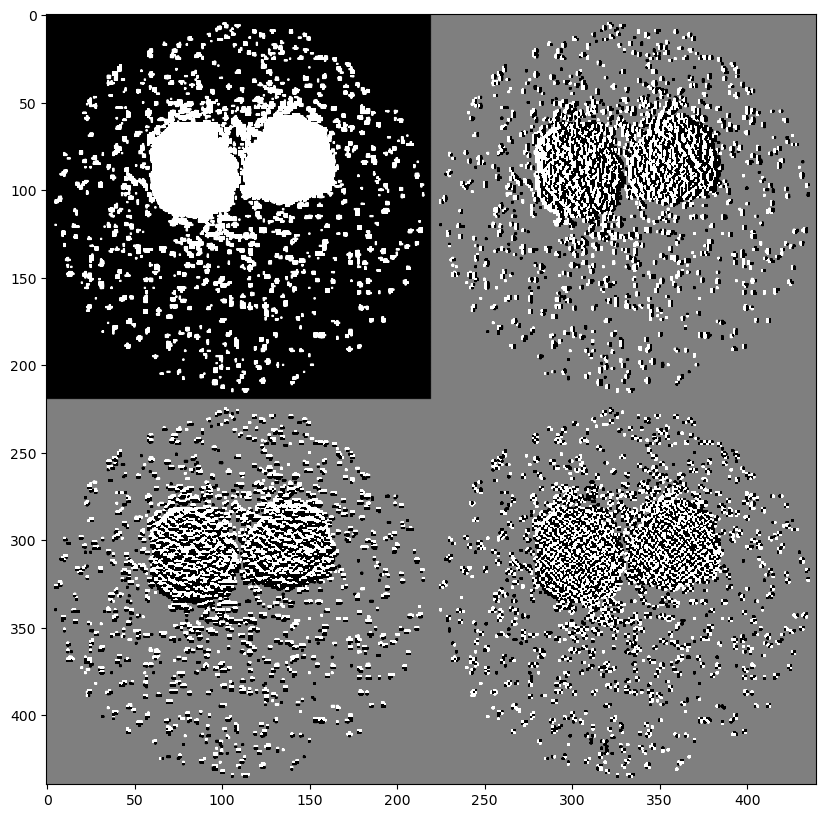

In [6]:
#1-level Haar Wavelet Transformation
haar = haar_wavelet(I,depth=1) #haar wavelet transform of full dose image 

#Fix up transform for viewing
n = I.shape[0]
haar[n>>1:,n>>1:] *= 4
haar[n>>1:,:] += 0.5   #Note n>>1 = n/2
haar[:n>>1,n>>1:]+= 0.5
haar[:n>>1,:n>>1] /= 4

#Plot transform
plt.figure(figsize=(10,10))
plt.imshow(haar,cmap='gray',vmin=0,vmax=1)

## 1-2 Dose

First do the wavelet and inverse wavelet transform for 1-2 dose.

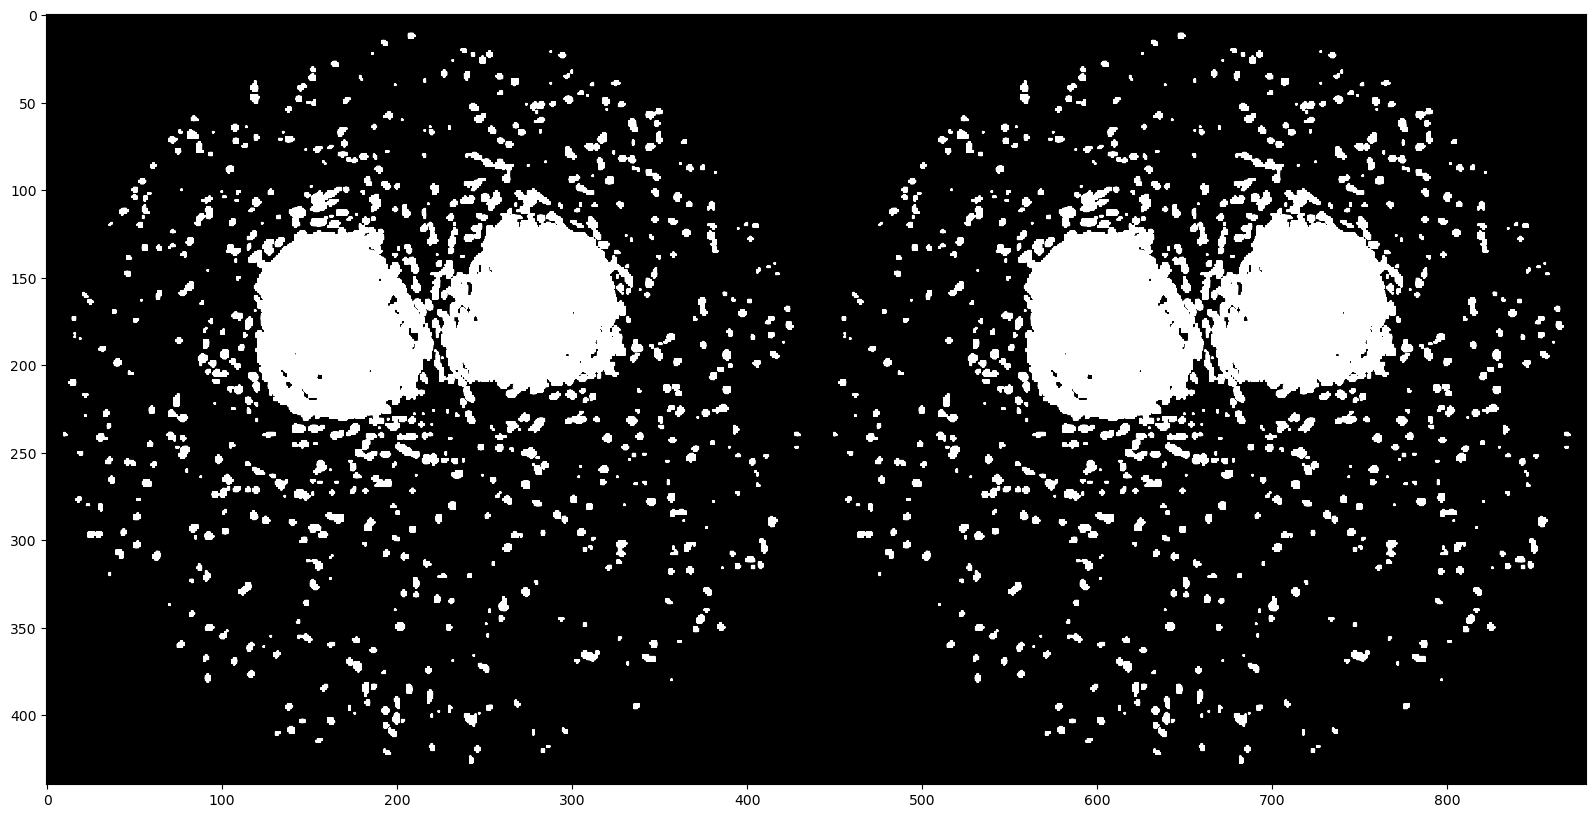

In [7]:
#1-2 Dose

#noisy image 
I_12= img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-2 dose/09062022_1.PT.10.644.2022.06.09.17.13.50.855000.4.0.193525746.IMA"))

#Wavelet denoising
depth = 2
thresh = 0.

#Wavelet transformation of noisy image 
wav = haar_wavelet(I_12,depth=depth)

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
I_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot noisy image vs denoised image 
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_12,I_denoised)),cmap='gray',vmin=0,vmax=1)

The plot displays a before and after of the 1-2 dose image with wavelet transformations.

In [8]:
MSE_wavelet = np.sum((I-I_denoised)**2)/I.size
PSNR_wavelet = 10*np.log10(np.max(I_denoised)**2/MSE_wavelet)
SSIM_wavelet = structural_similarity(I_denoised, I, full=True)
print("PSNR of Haar Wavelet:", PSNR_wavelet)
print("MSE of Haar Wavelet:", MSE_wavelet)
print("SSIM of Haar Wavelet:", SSIM_wavelet)

PSNR of Haar Wavelet: 39.91215189179916
MSE of Haar Wavelet: 82718.47669421487
SSIM of Haar Wavelet: (0.6169865475122999, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


Now do Total Variation + Wavelet Transform

In [9]:
TV_smooth=wavelet_tv_smooth(I_denoised,0.1)

/var/folders/rq/z0hq40p979q0vkb2y2b3k5sw0000gn/T/ipykernel_88421/2091952179.py:71: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)


In [10]:
MSE_TV = np.sum((I-TV_smooth)**2)/I.size
PSNR_TV = 10*np.log10(np.max(TV_smooth)**2/MSE_TV)
SSIM_TV = structural_similarity(TV_smooth, I, full=True)
print("PSNR of TV+Wavelet: ",PSNR_TV)
print("MSE of TV+Wavelet:", MSE_TV)
print("SSIM of TV+Wavelet:", SSIM_TV)

PSNR of TV+Wavelet:  39.91241645986976
MSE of TV+Wavelet: 82711.46314049586
SSIM of TV+Wavelet: (0.6127157963617872, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


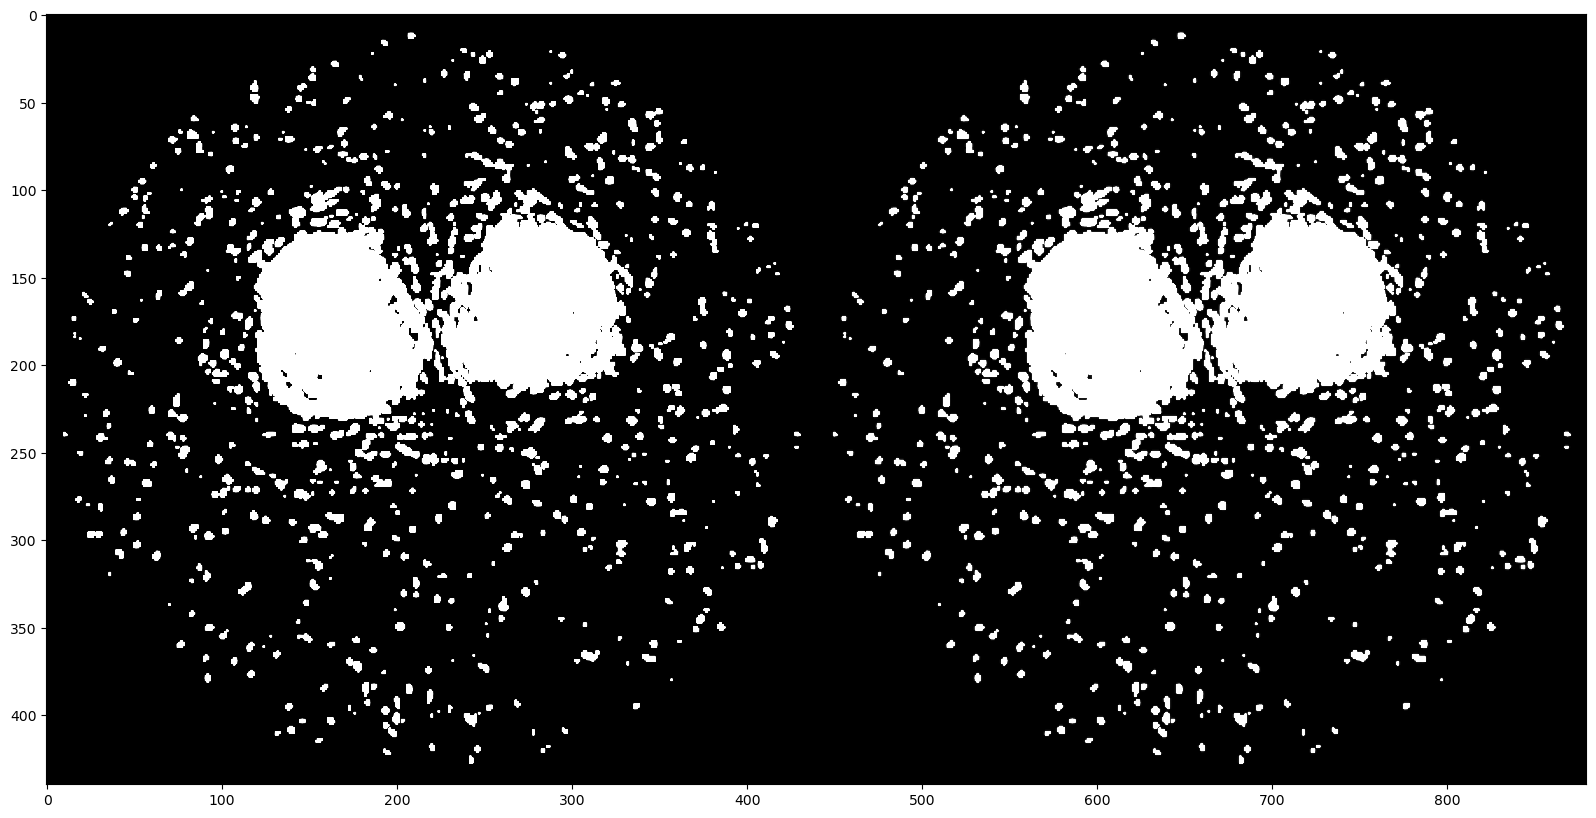

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_12,TV_smooth)),cmap='gray',vmin=0,vmax=1)  

## 1-4 Dose

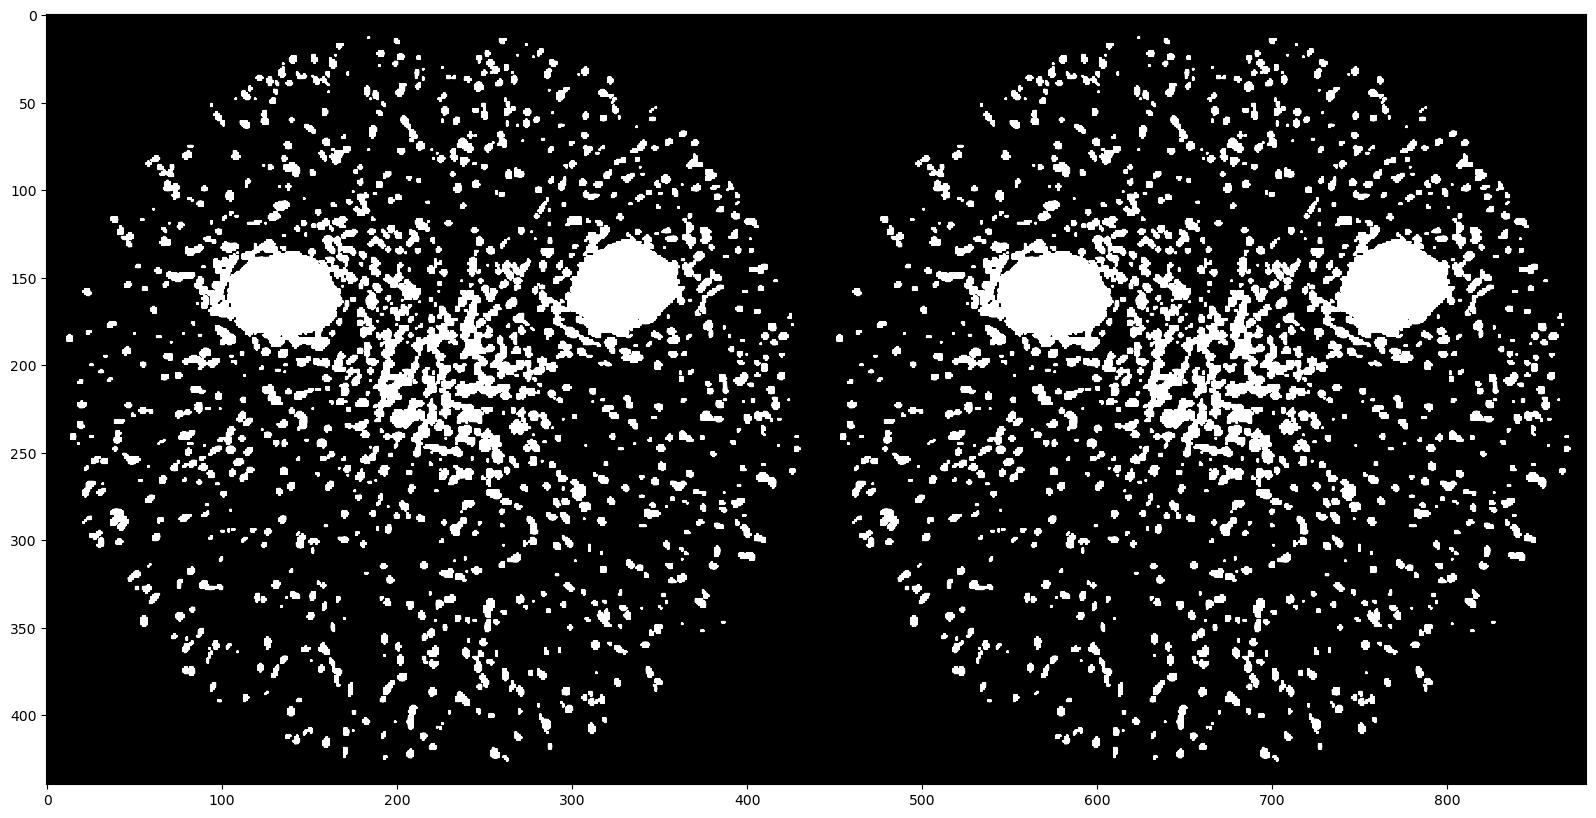

In [12]:
#1-4 Dose

#noisy image 
I_14= img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-4 dose/09062022_1.PT.12.2.2022.06.09.17.04.14.911000.4.0.193528514.IMA"))

#Wavelet denoising
depth = 2
thresh = 0.

#Wavelet transformation of noisy image 
wav = haar_wavelet(I_14,depth=depth) 

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
I_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot noisy image vs denoised image 
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_14,I_denoised)),cmap='gray',vmin=0,vmax=1)  


In [13]:
MSE_wavelet = np.sum((I-I_denoised)**2)/I.size
PSNR_wavelet = 10*np.log10(np.max(I_denoised)**2/MSE_wavelet)
SSIM_wavelet = structural_similarity(I_denoised, I, full=True)
print("PSNR of Haar Wavelet:", PSNR_wavelet)
print("MSE of Haar Wavelet:", MSE_wavelet)
print("SSIM of Haar Wavelet:", SSIM_wavelet)

PSNR of Haar Wavelet: 27.535296126894316
MSE of Haar Wavelet: 148105.573553719
SSIM of Haar Wavelet: (0.41980893256932234, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


In [14]:
TV_smooth=wavelet_tv_smooth(I_denoised,0.1)

/var/folders/rq/z0hq40p979q0vkb2y2b3k5sw0000gn/T/ipykernel_88421/2091952179.py:71: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)


In [15]:
MSE_TV = np.sum((I-TV_smooth)**2)/I.size
PSNR_TV = 10*np.log10(np.max(TV_smooth)**2/MSE_TV)
SSIM_TV = structural_similarity(TV_smooth, I, full=True)
print("PSNR of TV+Wavelet: ",PSNR_TV)
print("MSE of TV+Wavelet:", MSE_TV)
print("SSIM of TV+Wavelet:", SSIM_TV)

PSNR of TV+Wavelet:  27.535178786430116
MSE of TV+Wavelet: 148100.1361983471
SSIM of TV+Wavelet: (0.41528376663418515, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


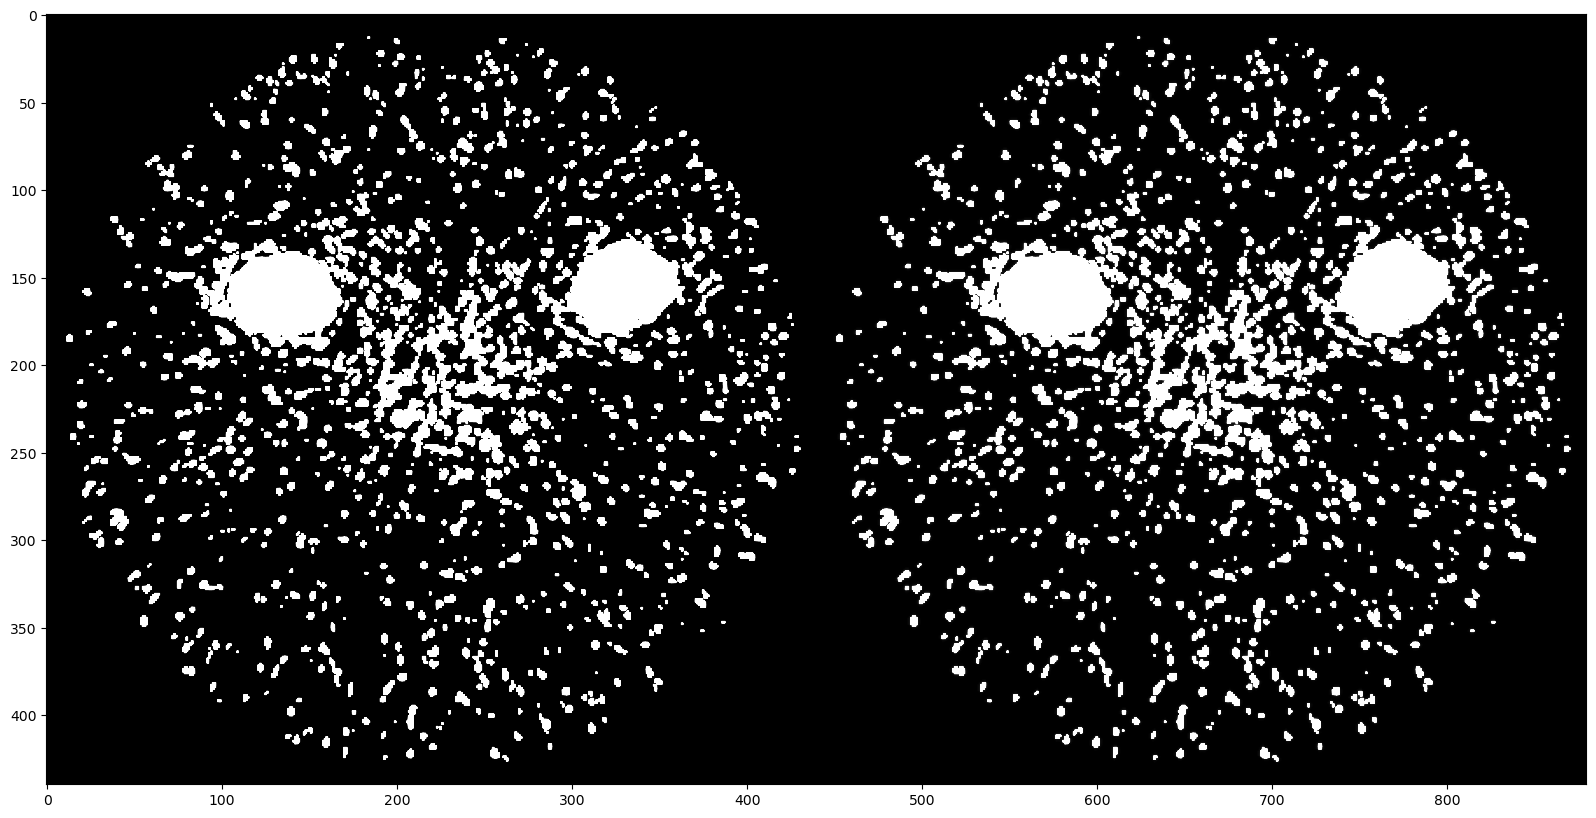

In [16]:
#plot of noisy image and TV+wavelet denoised image
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_14,TV_smooth)),cmap='gray',vmin=0,vmax=1)  

## 1-10 Dose 

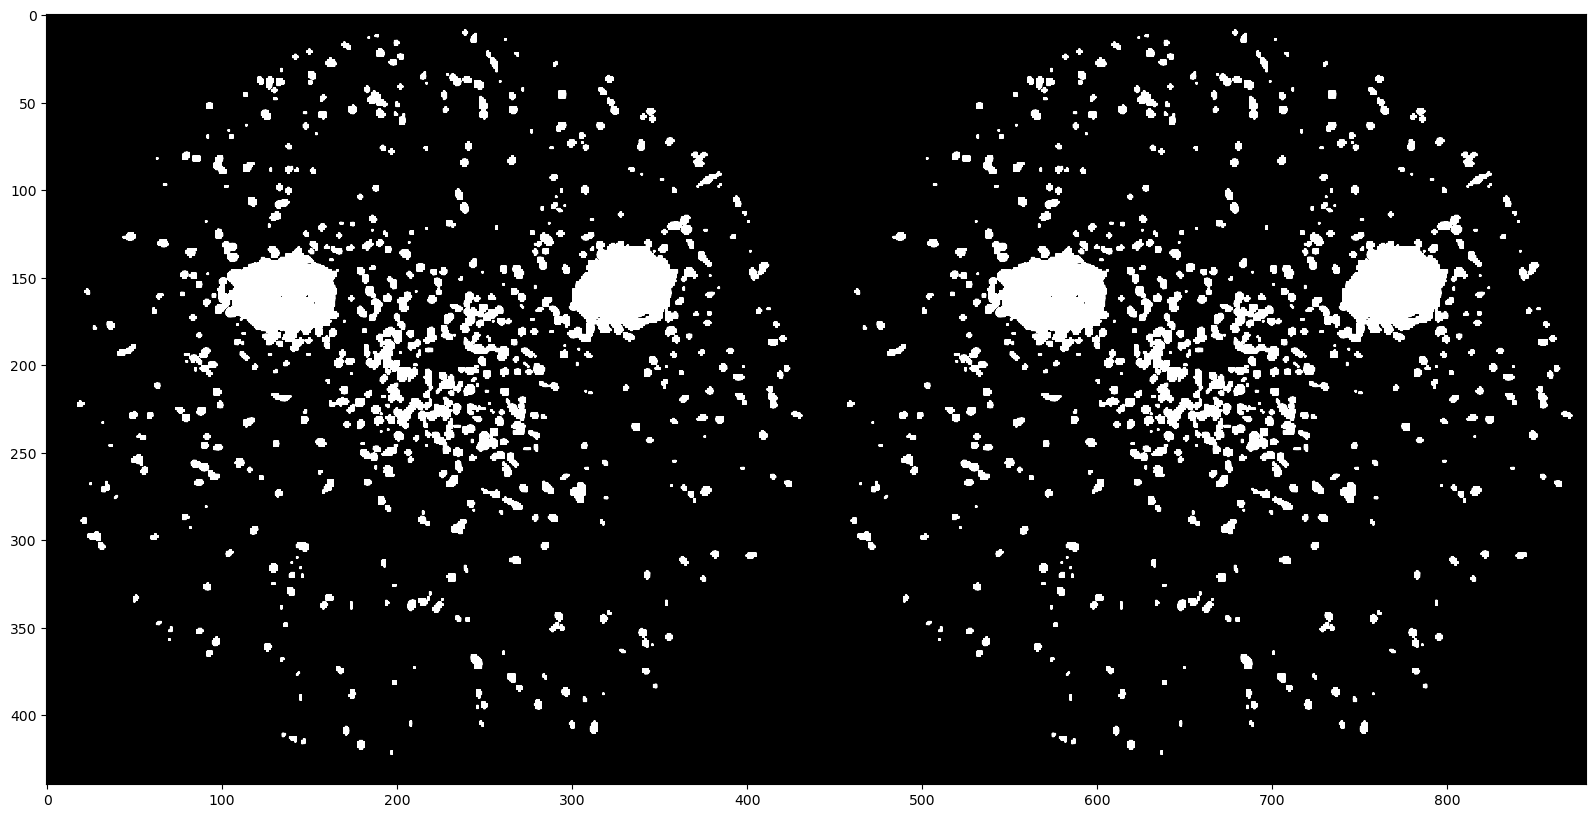

In [17]:
#1-10 Dose

#noisy image 
I_110= img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-10 dose/09062022_1.PT.16.1.2022.06.09.17.23.06.069000.4.0.193586079.IMA"))

#Wavelet denoising
depth = 2
thresh = 0.

#Wavelet transformation of noisy image 
wav = haar_wavelet(I_110,depth=depth) 

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
I_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot noisy image vs denoised image 
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_110,I_denoised)),cmap='gray',vmin=0,vmax=1)  


In [18]:
MSE_wavelet = np.sum((I-I_denoised)**2)/I.size
PSNR_wavelet = 10*np.log10(np.max(I_denoised)**2/MSE_wavelet)
SSIM_wavelet = structural_similarity(I_denoised, I, full=True)
print("PSNR of Haar Wavelet:", PSNR_wavelet)
print("MSE of Haar Wavelet:", MSE_wavelet)
print("SSIM of Haar Wavelet:", SSIM_wavelet)

PSNR of Haar Wavelet: 36.803516678945684
MSE of Haar Wavelet: 212215.09289256198
SSIM of Haar Wavelet: (0.5149265694502086, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


In [19]:
TV_smooth=wavelet_tv_smooth(I_denoised,0.1)

/var/folders/rq/z0hq40p979q0vkb2y2b3k5sw0000gn/T/ipykernel_88421/2091952179.py:71: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)


In [20]:
MSE_TV = np.sum((I-TV_smooth)**2)/I.size
PSNR_TV = 10*np.log10(np.max(TV_smooth)**2/MSE_TV)
SSIM_TV = structural_similarity(TV_smooth, I, full=True)
print("PSNR of TV+Wavelet: ",PSNR_TV)
print("MSE of TV+Wavelet:", MSE_TV)
print("SSIM of TV+Wavelet:", SSIM_TV)

PSNR of TV+Wavelet:  36.803603601051385
MSE of TV+Wavelet: 212206.84165289256
SSIM of TV+Wavelet: (0.5120676454668784, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


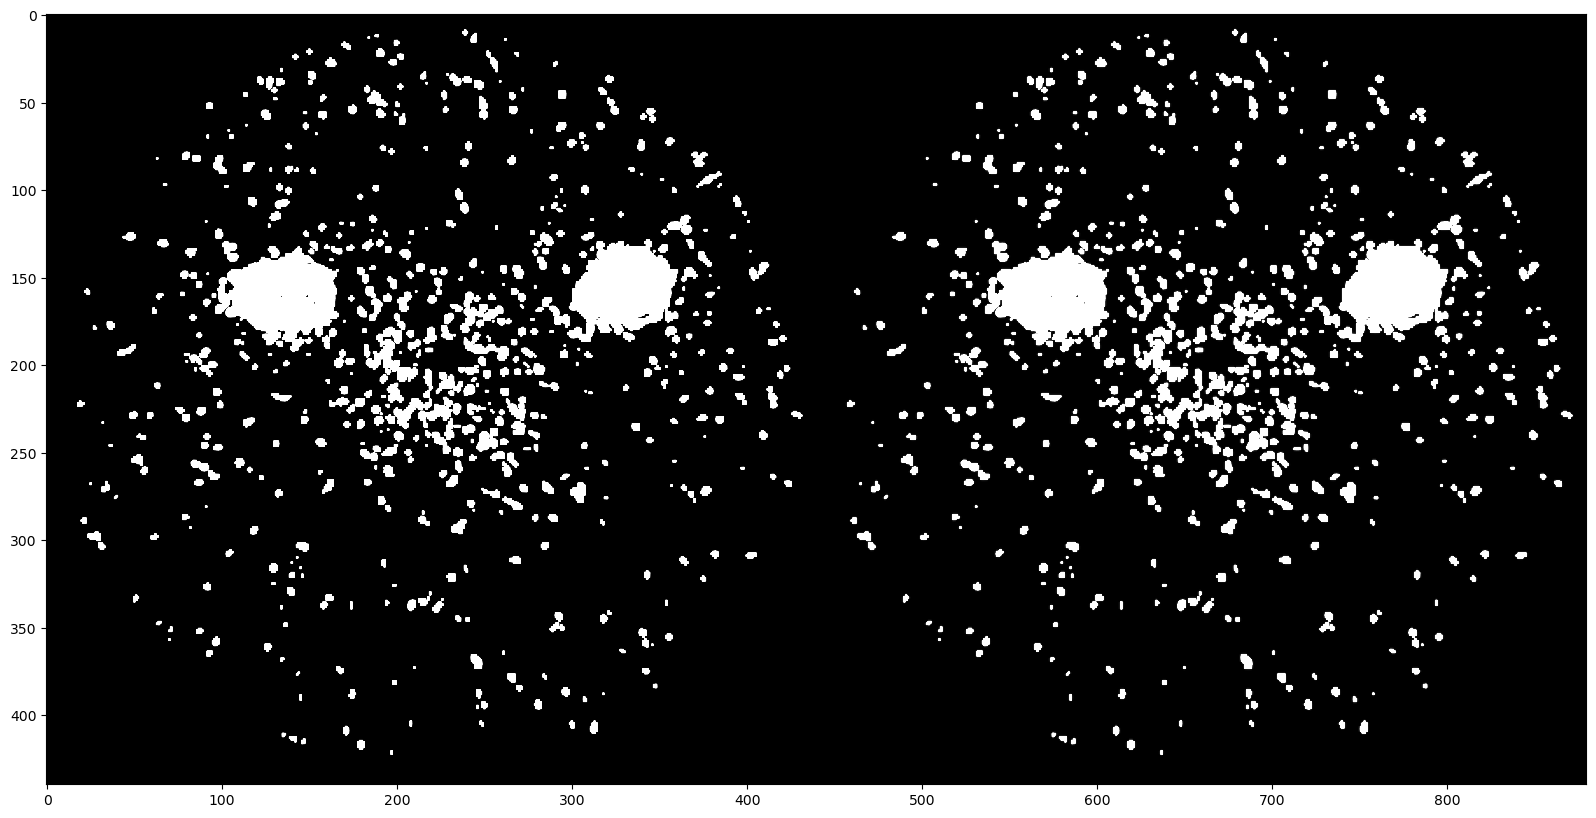

In [21]:
#plot of noisy image and TV+wavelet denoised image
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_110,TV_smooth)),cmap='gray',vmin=0,vmax=1) 

## 1-20 Dose

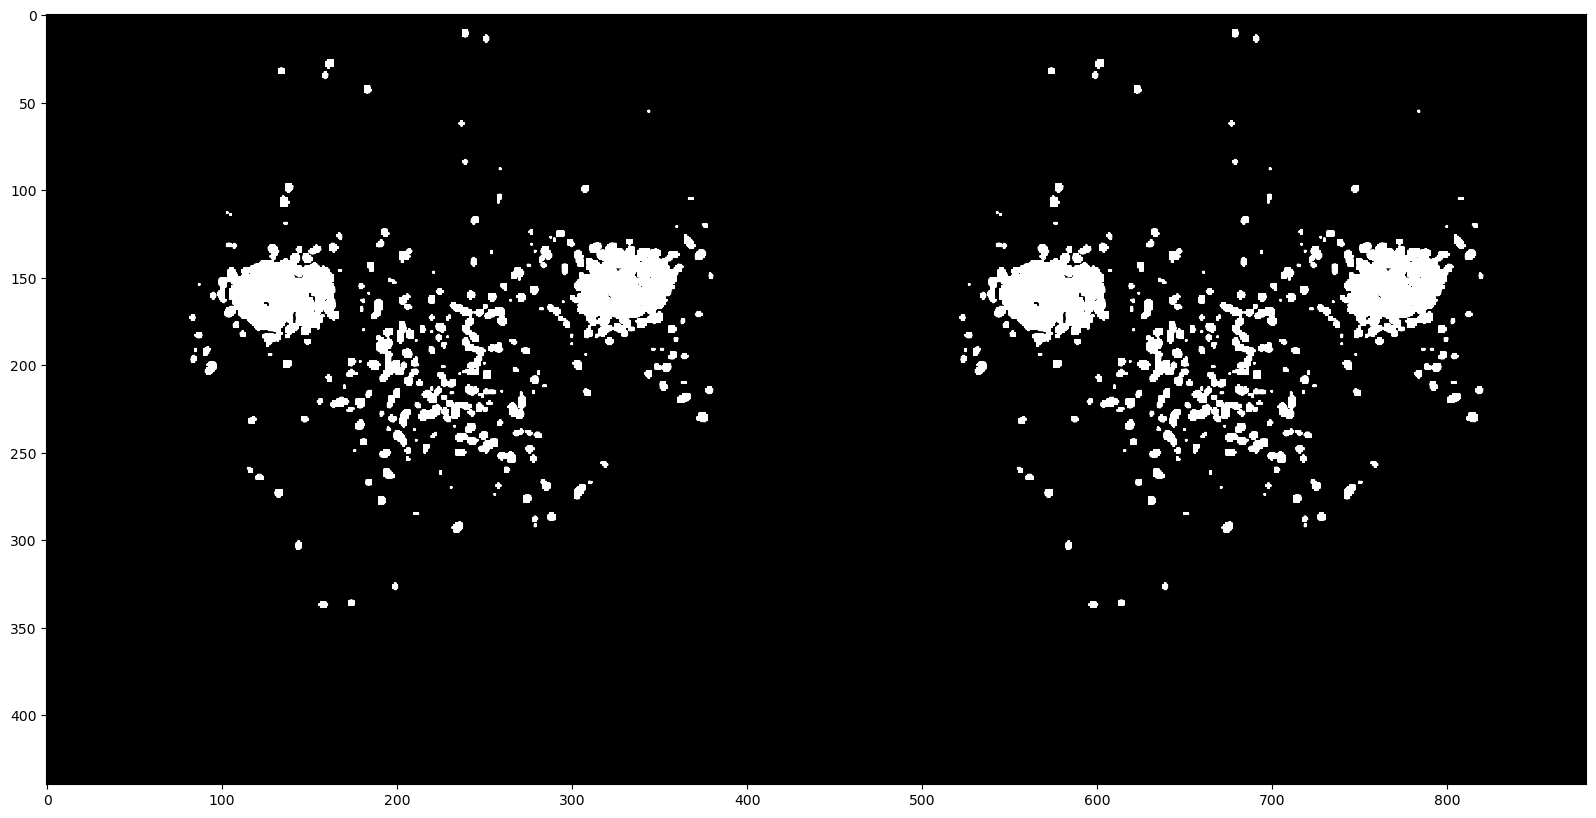

In [22]:
#1-20 Dose

#noisy image 
I_120= img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-20 dose/09062022_1.PT.19.1.2022.06.09.17.53.27.095000.4.0.193634440.IMA"))

#Wavelet denoising
depth = 2
thresh = 0.

#Wavelet transformation of noisy image 
wav = haar_wavelet(I_120,depth=depth) 

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
I_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot noisy image vs denoised image 
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_120,I_denoised)),cmap='gray',vmin=0,vmax=1)  


In [23]:
MSE_wavelet = np.sum((I-I_denoised)**2)/I.size
PSNR_wavelet = 10*np.log10(np.max(I_denoised)**2/MSE_wavelet)
SSIM_wavelet = structural_similarity(I_denoised, I, full=True)
print("PSNR of Haar Wavelet:", PSNR_wavelet)
print("MSE of Haar Wavelet:", MSE_wavelet)
print("SSIM of Haar Wavelet:", SSIM_wavelet)

PSNR of Haar Wavelet: 35.90426389373573
MSE of Haar Wavelet: 281541.01421487605
SSIM of Haar Wavelet: (0.58866399367934, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


In [24]:
TV_smooth=wavelet_tv_smooth(I_denoised,0.1)

/var/folders/rq/z0hq40p979q0vkb2y2b3k5sw0000gn/T/ipykernel_88421/2091952179.py:71: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)


In [25]:
MSE_TV = np.sum((I-TV_smooth)**2)/I.size
PSNR_TV = 10*np.log10(np.max(TV_smooth)**2/MSE_TV)
SSIM_TV = structural_similarity(TV_smooth, I, full=True)
print("PSNR of TV+Wavelet: ",PSNR_TV)
print("MSE of TV+Wavelet:", MSE_TV)
print("SSIM of TV+Wavelet:", SSIM_TV)

PSNR of TV+Wavelet:  35.90431857448663
MSE of TV+Wavelet: 281532.02247933886
SSIM of TV+Wavelet: (0.587928265475035, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


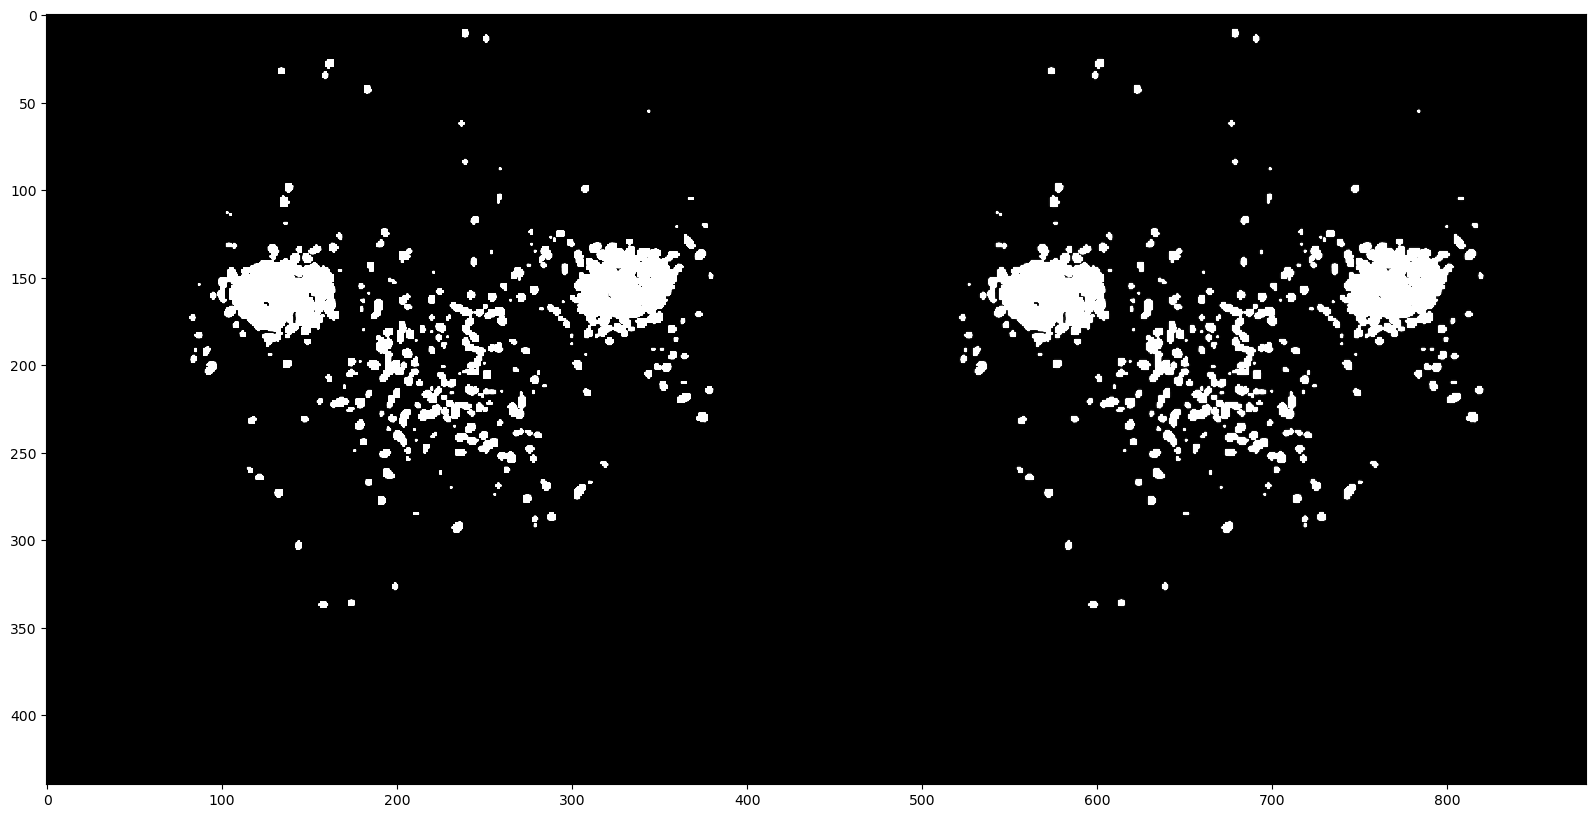

In [26]:
#plot of noisy image and TV+wavelet denoised image
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_120,TV_smooth)),cmap='gray',vmin=0,vmax=1) 

## 1-50 Dose

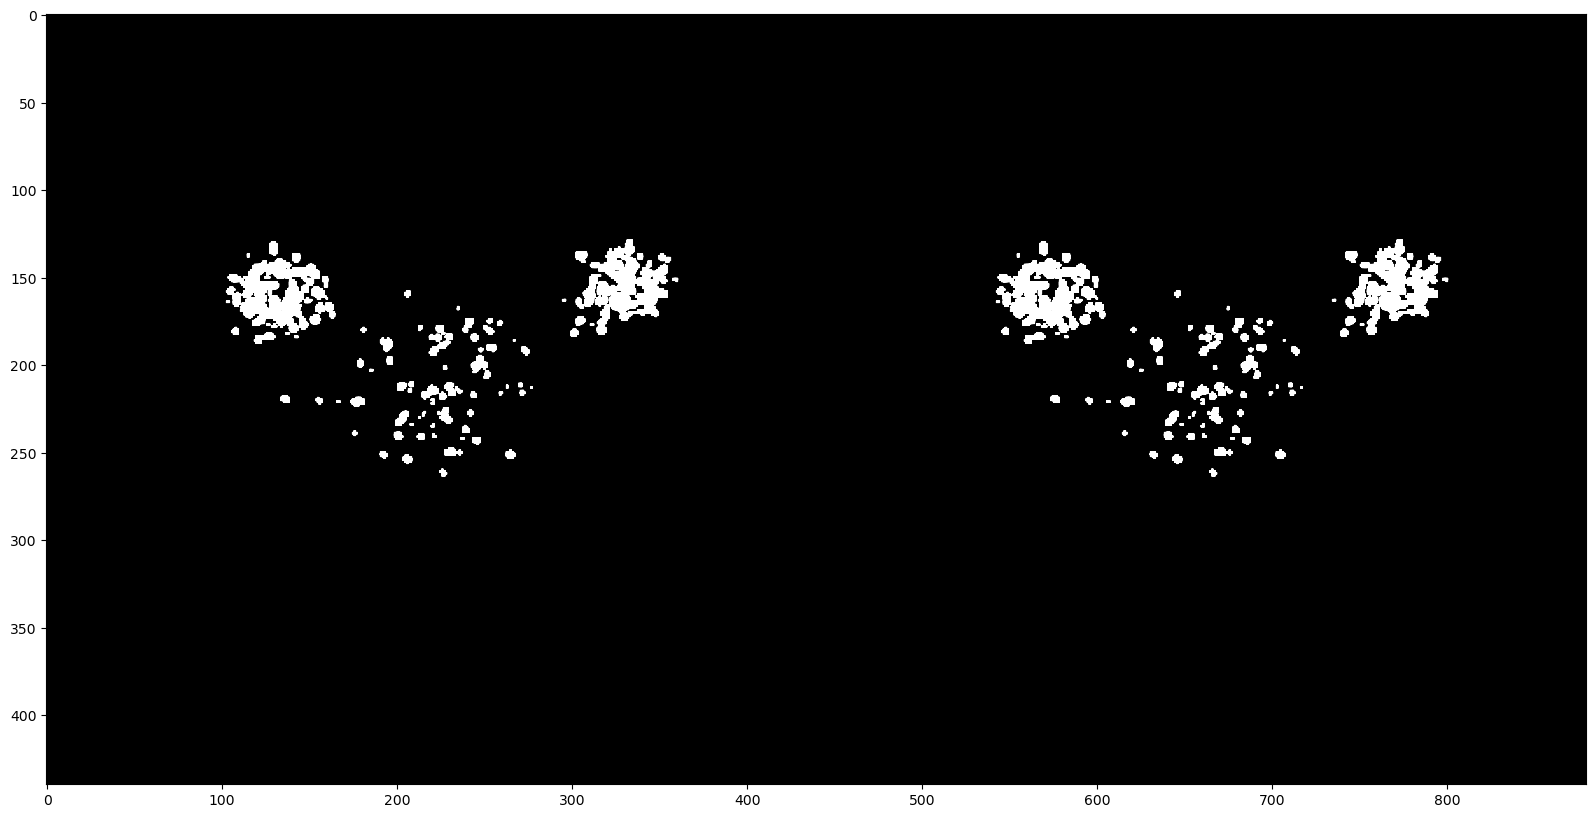

In [27]:
#1-50 Dose

#noisy image 
I_150= img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-50 dose/09062022_1.PT.21.1.2022.06.09.17.43.00.548000.4.0.193664365.IMA"))

#Wavelet denoising
depth = 2
thresh = 0.

#Wavelet transformation of noisy image 
wav = haar_wavelet(I_150,depth=depth) 

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
I_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot noisy image vs denoised image 
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_150,I_denoised)),cmap='gray',vmin=0,vmax=1)  


In [28]:
MSE_wavelet = np.sum((I-I_denoised)**2)/I.size
PSNR_wavelet = 10*np.log10(np.max(I_denoised)**2/MSE_wavelet)
SSIM_wavelet = structural_similarity(I_denoised, I, full=True)
print("PSNR of Haar Wavelet:", PSNR_wavelet)
print("MSE of Haar Wavelet:", MSE_wavelet)
print("SSIM of Haar Wavelet:", SSIM_wavelet)

PSNR of Haar Wavelet: 41.114802465915446
MSE of Haar Wavelet: 655485.4611570248
SSIM of Haar Wavelet: (0.6099609892269499, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


In [29]:
TV_smooth=wavelet_tv_smooth(I_denoised,0.1)

/var/folders/rq/z0hq40p979q0vkb2y2b3k5sw0000gn/T/ipykernel_88421/2091952179.py:71: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)


In [30]:
MSE_TV = np.sum((I-TV_smooth)**2)/I.size
PSNR_TV = 10*np.log10(np.max(TV_smooth)**2/MSE_TV)
SSIM_TV = structural_similarity(TV_smooth, I, full=True)
print("PSNR of TV+Wavelet: ",PSNR_TV)
print("MSE of TV+Wavelet:", MSE_TV)
print("SSIM of TV+Wavelet:", SSIM_TV)

PSNR of TV+Wavelet:  41.11484159256616
MSE of TV+Wavelet: 655474.882644628
SSIM of TV+Wavelet: (0.6098231057743801, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


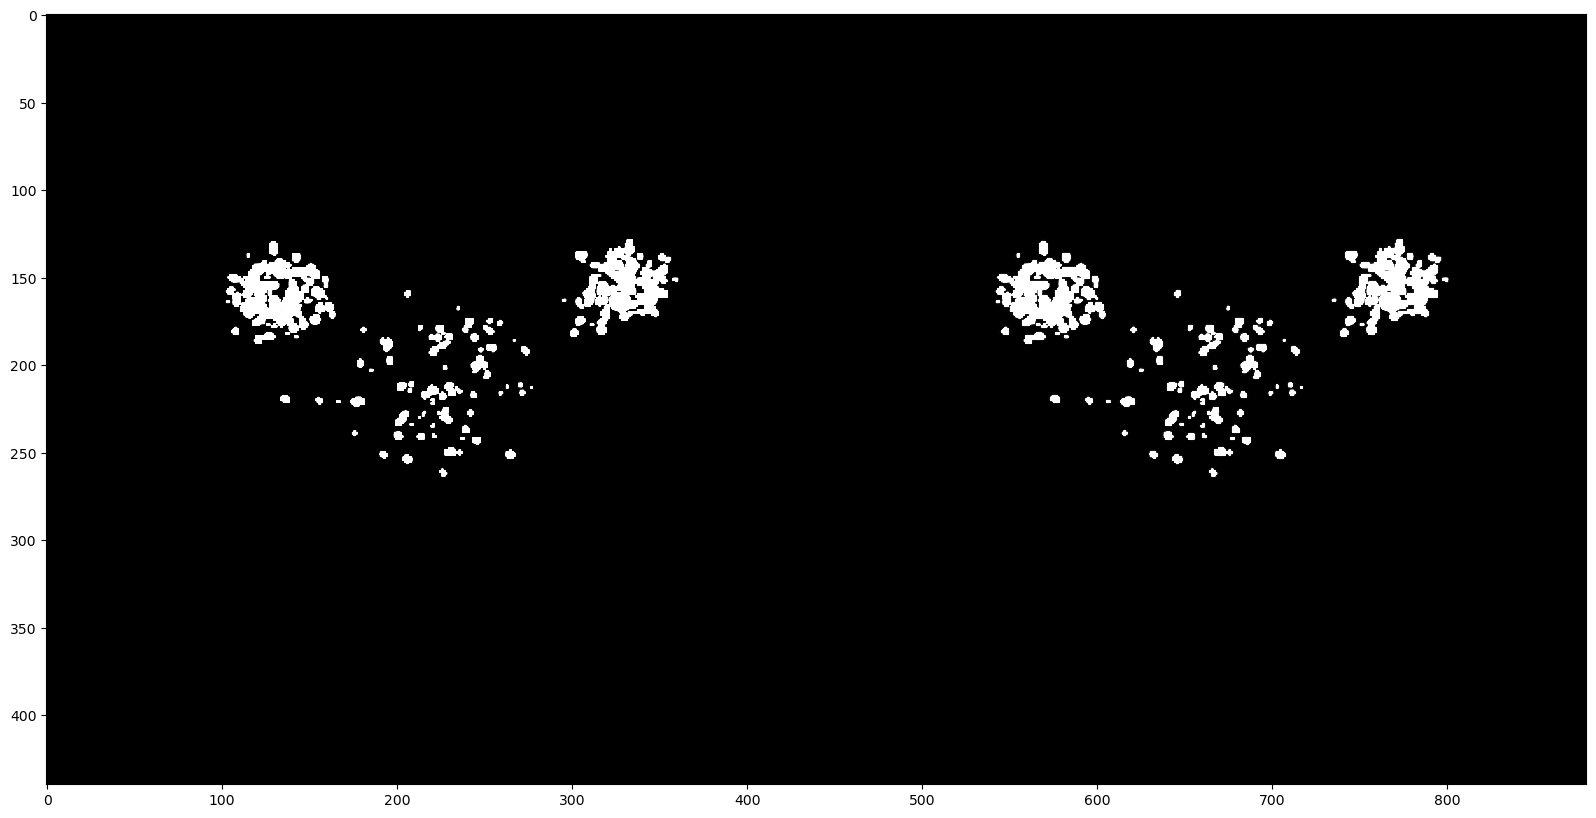

In [31]:
#plot of noisy image and TV+wavelet denoised image
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_150,TV_smooth)),cmap='gray',vmin=0,vmax=1) 

## 1-100 Dose

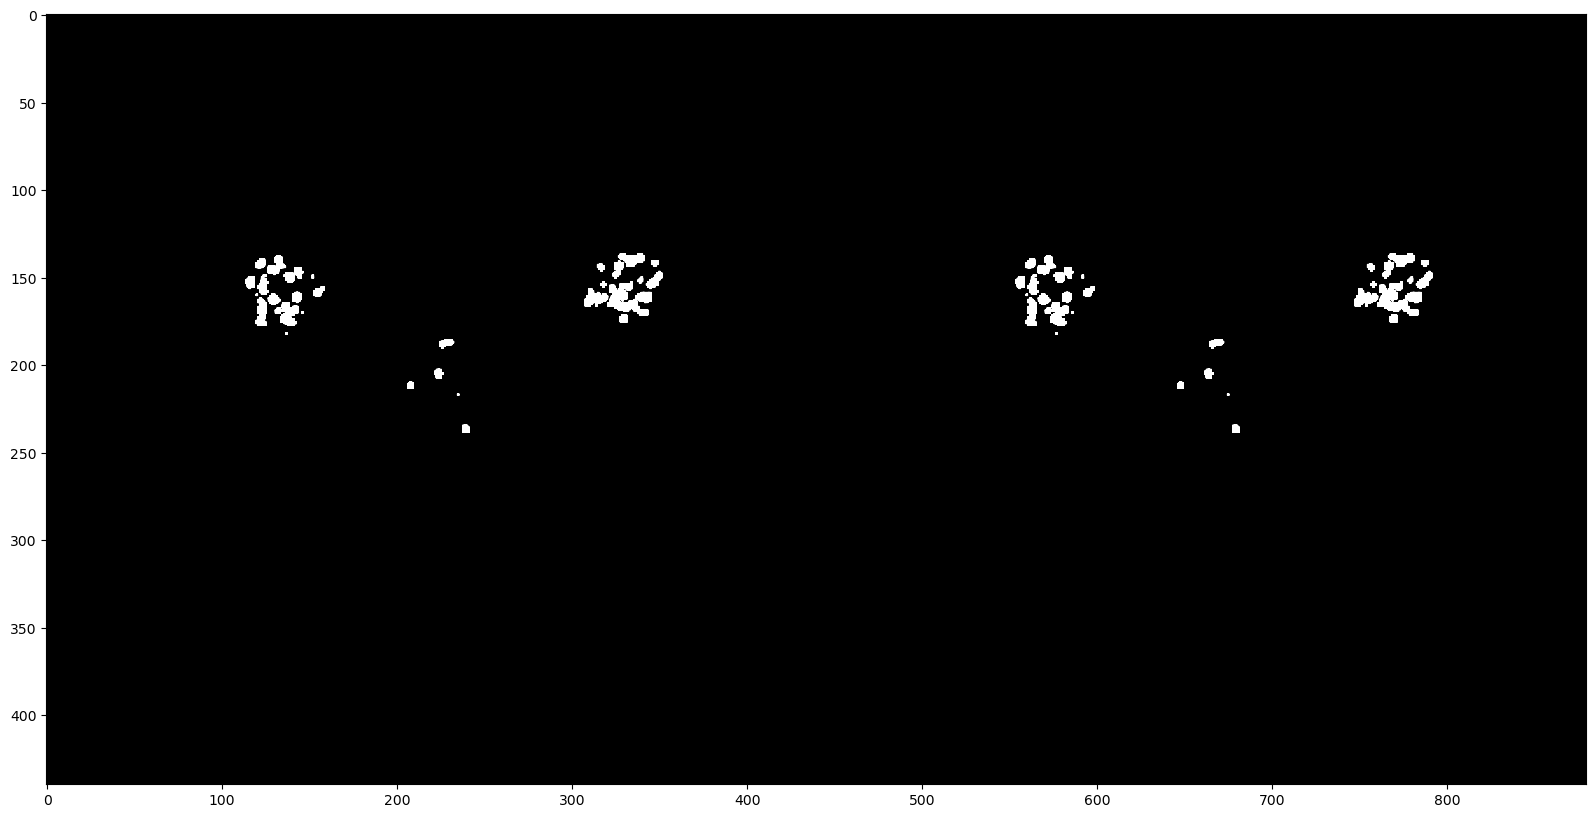

In [40]:
#1-100 Dose

#noisy image 
I_1100= img_as_float(io.imread("/Users/toriwright/Downloads/Medical Imaging/SVD/Siemens Vision Quadra 17/Subject_136-141/09062022_1_20220609_163454/1-100 dose/09062022_1.PT.22.1.2022.06.09.17.33.23.131000.4.0.193684044.IMA"))
#Wavelet denoising
depth = 2
thresh = 0.

#Wavelet transformation of noisy image 
wav = haar_wavelet(I_1100,depth=depth) 

#Threshold detail coefficients
wav_thresh = wav * (np.absolute(wav) > thresh)
wav_thresh[:n>>depth,:n>>depth] = wav[:n>>depth,:n>>depth]

#Inverse transform
I_denoised = inverse_haar_wavelet(wav_thresh,depth=depth)

#Plot noisy image vs denoised image 
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_1100,I_denoised)),cmap='gray',vmin=0,vmax=1)  


In [33]:
MSE_wavelet = np.sum((I-I_denoised)**2)/I.size
PSNR_wavelet = 10*np.log10(np.max(I_denoised)**2/MSE_wavelet)
SSIM_wavelet = structural_similarity(I_denoised, I, full=True)
print("PSNR of Haar Wavelet:", PSNR_wavelet)
print("MSE of Haar Wavelet:", MSE_wavelet)
print("SSIM of Haar Wavelet:", SSIM_wavelet)

PSNR of Haar Wavelet: 44.16774619092977
MSE of Haar Wavelet: 605502.2862809917
SSIM of Haar Wavelet: (0.6144385059295765, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


In [34]:
TV_smooth=wavelet_tv_smooth(I_denoised,0.1)

/var/folders/rq/z0hq40p979q0vkb2y2b3k5sw0000gn/T/ipykernel_88421/2091952179.py:71: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoise_TV = denoise_tv_chambolle(g, weight=w, multichannel=False)


In [35]:
MSE_TV = np.sum((I-TV_smooth)**2)/I.size
PSNR_TV = 10*np.log10(np.max(TV_smooth)**2/MSE_TV)
SSIM_TV = structural_similarity(TV_smooth, I, full=True)
print("PSNR of TV+Wavelet: ",PSNR_TV)
print("MSE of TV+Wavelet:", MSE_TV)
print("SSIM of TV+Wavelet:", SSIM_TV)

PSNR of TV+Wavelet:  44.16775909962596
MSE of TV+Wavelet: 605497.2509090909
SSIM of TV+Wavelet: (0.6143811459531624, array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))


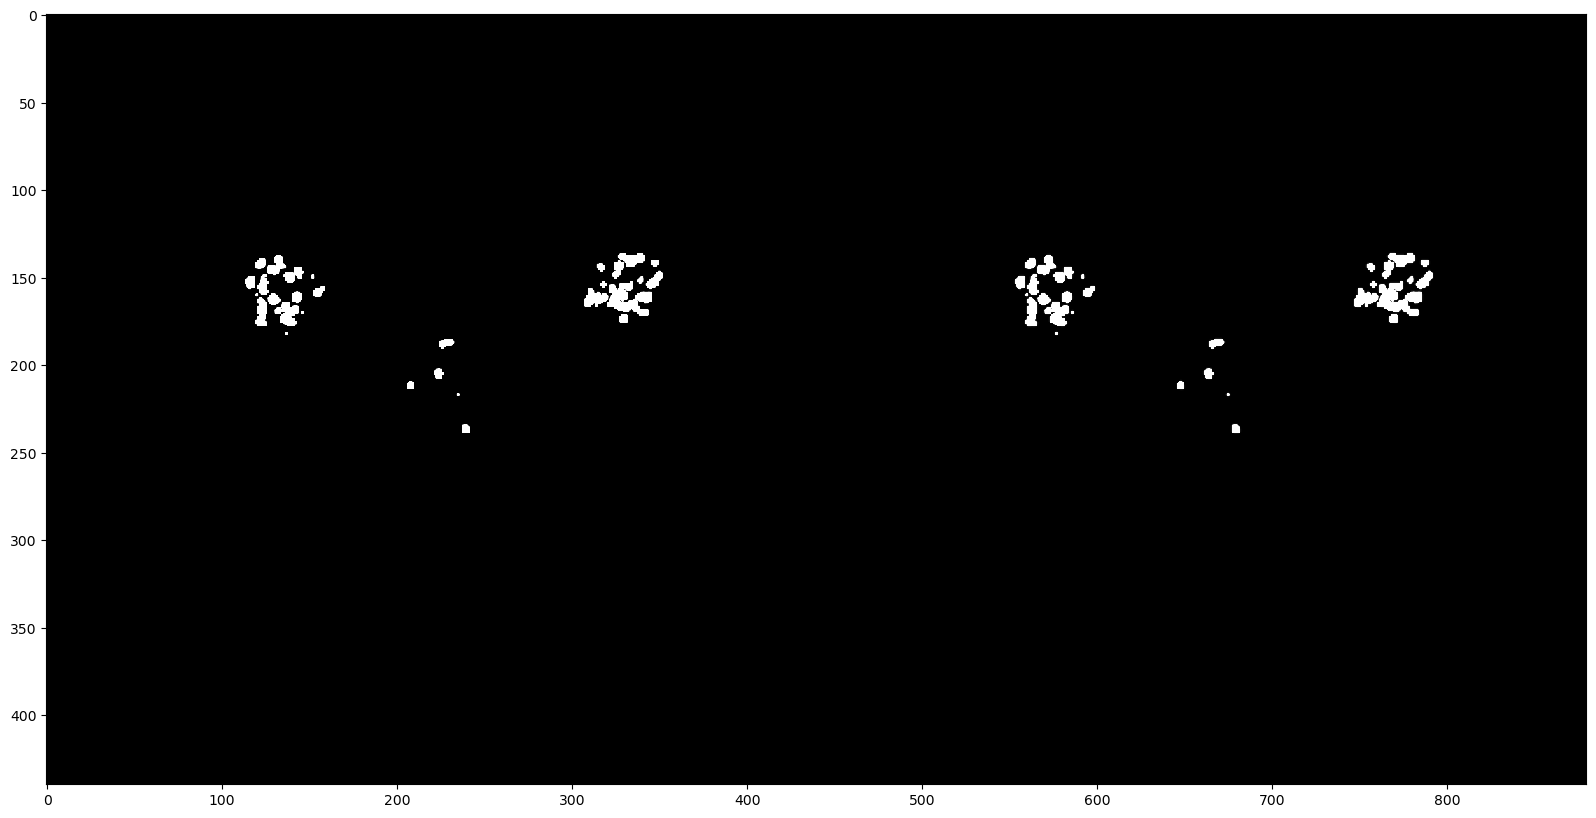

In [36]:
#plot of noisy image and TV+wavelet denoised image
plt.figure(figsize=(20,10))
plt.imshow(np.hstack((I_1100,TV_smooth)),cmap='gray',vmin=0,vmax=1) 